# CVE.ICU - Predictions
---

This notebook will pull all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and performs some basic time series forecasting using [Prophet](https://facebook.github.io/prophet/) from Facebook.  If you have any questions or suggestions, please join the [discussion here](https://github.com/jgamblin/cve.icu/discussions) and check out the [source code](https://github.com/jgamblin/cve.icu/).  Questions? Reach out to [@jgamblin](https://www.twitter.com/jgamblin).

**Year Data**
-  [All](Index.html)
-  [2021](2021.html)
-  [2020](2020.html)
-  [2019](2019.html)
-  [CVE Predcitions](predictions.htnl)

In [1]:
import datetime
import glob
import json
import logging
import sys
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
logging.disable(sys.maxsize)

Importing plotly failed. Interactive plots will not work.


In [2]:
row_accumulator = []
for filename in glob.glob('*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = 'Missing_Data_JG'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd = pd.DataFrame(row_accumulator)

nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
per_day = nvdcount/nvdunique
per_day = round(per_day, 0)

## Predictions

In [3]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day}**")

Total Number of CVEs: **166827**<br />Average CVEs Per Day: **26.0**

In [4]:
cve_day = pd.DataFrame(nvd.Published.value_counts().reset_index().values, columns=["ds", "y"])
cve_day = cve_day.sort_index(axis = 0, ascending=True)
cve_day = cve_day[cve_day['y'] <= 400]  

In [5]:
m = Prophet()
m.fit(cve_day)
future = m.make_future_dataframe(periods=3650)

Initial log joint probability = -41.3735
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       13182.2    0.00084106       128.886           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       13183.6   7.02245e-05       93.0903   5.371e-07       0.001      295  LS failed, Hessian reset 
     199       13183.7   0.000260364       70.8147           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       13183.8   8.41411e-06        43.443   1.661e-07       0.001      440  LS failed, Hessian reset 
     280       13183.8    4.7685e-05       74.9582   7.631e-07       0.001      502  LS failed, Hessian reset 
     299       13183.8   7.27843e-06       47.0348           1           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

### Prediction Per Year

In [6]:
forecast = m.predict(future)
by_year = forecast.copy()
result = by_year.groupby(by_year.ds.dt.to_period("Y"))['yhat'].sum().round()

for year, records in result.items():
    print(f"{year} - {records} CVEs")

1988 - -39.0 CVEs
1989 - -25.0 CVEs
1990 - -15.0 CVEs
1991 - -35.0 CVEs
1992 - -30.0 CVEs
1993 - 15.0 CVEs
1994 - 2.0 CVEs
1995 - 27.0 CVEs
1996 - 122.0 CVEs
1997 - 245.0 CVEs
1998 - 383.0 CVEs
1999 - 989.0 CVEs
2000 - 988.0 CVEs
2001 - 1594.0 CVEs
2002 - 1139.0 CVEs
2003 - 1235.0 CVEs
2004 - 2631.0 CVEs
2005 - 4374.0 CVEs
2006 - 5421.0 CVEs
2007 - 5639.0 CVEs
2008 - 5639.0 CVEs
2009 - 5802.0 CVEs
2010 - 4651.0 CVEs
2011 - 4482.0 CVEs
2012 - 5278.0 CVEs
2013 - 5777.0 CVEs
2014 - 6805.0 CVEs
2015 - 7771.0 CVEs
2016 - 8748.0 CVEs
2017 - 12654.0 CVEs
2018 - 15028.0 CVEs
2019 - 16600.0 CVEs
2020 - 18226.0 CVEs
2021 - 20696.0 CVEs
2022 - 23880.0 CVEs
2023 - 25985.0 CVEs
2024 - 28198.0 CVEs
2025 - 30233.0 CVEs
2026 - 32334.0 CVEs
2027 - 34436.0 CVEs
2028 - 36610.0 CVEs
2029 - 38654.0 CVEs
2030 - 40765.0 CVEs
2031 - 42495.0 CVEs


### Plot the Forecast

This shows the plot for all previous data and the next 10 years. 

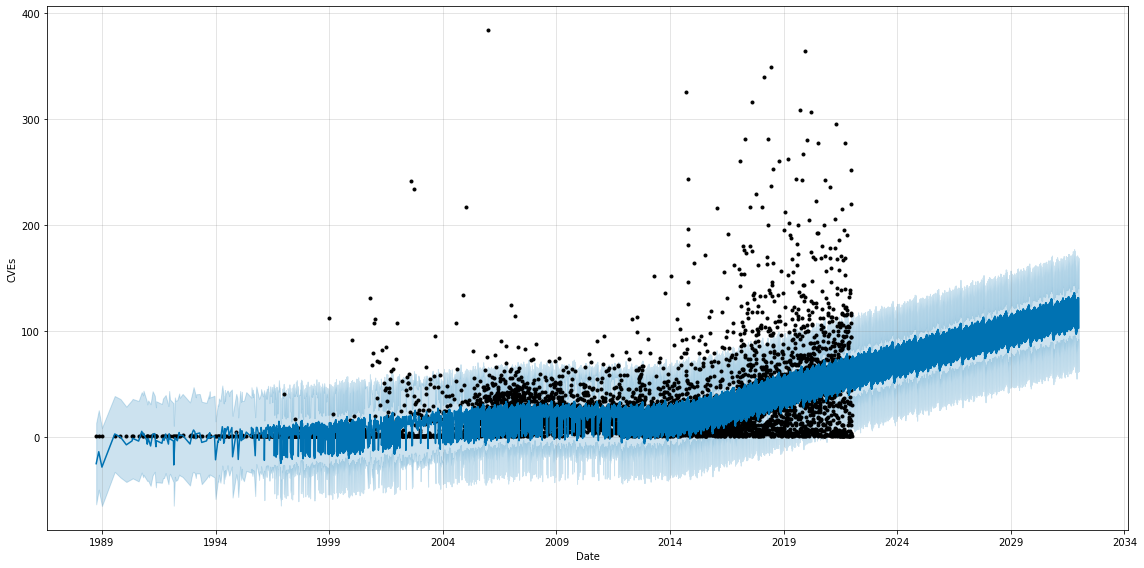

In [7]:

fig = m.plot(forecast, xlabel='Date', ylabel='CVEs', figsize=(16, 8) )

### Plot the Forecast With Change Points

This shows the plot for all previous data and the next 10 years with changepoints marked where the data had abrupt changes in its trajectories.

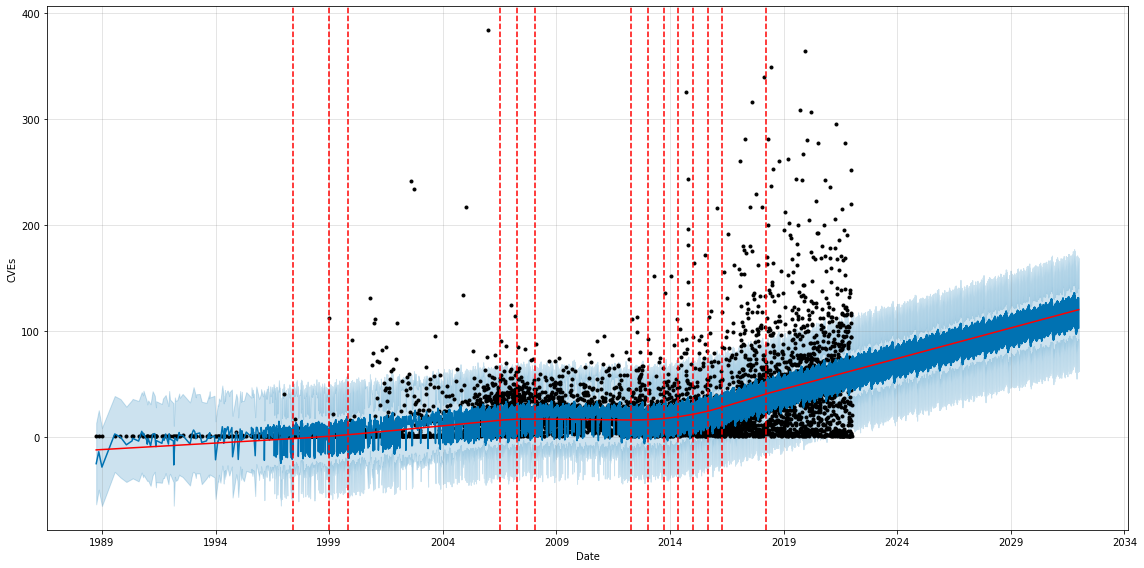

In [8]:
fig = m.plot(forecast, xlabel='Date', ylabel='CVEs', figsize=(16, 8))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Most CVE Per Day Predictions For The Next Year

In [9]:
date_now = datetime.now()
one_year = date_now + pd.DateOffset(years=1)
five_year = date_now + pd.DateOffset(years=5)
ten_year = date_now + pd.DateOffset(years=10)


cve_prophet_thisyear = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < one_year)]
cve_prophet_thisyear =  cve_prophet_thisyear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_thisyear

,ds,yhat,yhat_lower,yhat_upper
6665,2022-10-19,84.0,47.0,120.0
6658,2022-10-12,84.0,47.0,121.0
6672,2022-10-26,83.0,44.0,119.0
6651,2022-10-05,82.0,42.0,120.0
6574,2022-07-20,81.0,44.0,117.0
6637,2022-09-21,81.0,45.0,118.0
6644,2022-09-28,81.0,44.0,119.0
6666,2022-10-20,80.0,42.0,119.0
6735,2022-12-28,80.0,42.0,115.0
6630,2022-09-14,80.0,40.0,119.0


### Most CVE Per Day Predictions For The Next 5 Years

In [10]:
cve_prophet_next5 = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < five_year)]
cve_prophet_next5 = cve_prophet_next5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_next5

,ds,yhat,yhat_lower,yhat_upper
8121,2026-10-14,107.0,71.0,148.0
8128,2026-10-21,107.0,68.0,142.0
8114,2026-10-07,106.0,68.0,143.0
8107,2026-09-30,105.0,67.0,140.0
8135,2026-10-28,105.0,68.0,140.0
8030,2026-07-15,104.0,65.0,142.0
8100,2026-09-23,104.0,65.0,140.0
8037,2026-07-22,104.0,64.0,141.0
8129,2026-10-22,103.0,69.0,143.0
8093,2026-09-16,103.0,66.0,141.0


### Most CVE Per Day Predictions For The Next 10 Years

In [11]:
cve_prophet_next10 = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < ten_year)]
cve_prophet_next10 = cve_prophet_next10[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_next10

,ds,yhat,yhat_lower,yhat_upper
9948,2031-10-15,136.0,96.0,177.0
9955,2031-10-22,136.0,96.0,176.0
9941,2031-10-08,135.0,96.0,173.0
9934,2031-10-01,134.0,95.0,173.0
9962,2031-10-29,133.0,93.0,174.0
9927,2031-09-24,133.0,96.0,175.0
9913,2031-09-10,132.0,91.0,171.0
9857,2031-07-16,132.0,93.0,173.0
9920,2031-09-17,132.0,92.0,173.0
9949,2031-10-16,132.0,93.0,172.0
